In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.dummy import DummyRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import os
import warnings
warnings.filterwarnings('ignore')


### Preprocessing

In [2]:
os.makedirs('./output_csv', exist_ok=True)
df = pd.read_csv('../build_dataset/output_csv/bloomberg_data.csv')
df = df.dropna(subset=['Offer To 1st Close'])
df.head(3)

,Issuer Ticker,Issuer Name,Offer Size (M),Sales - 1 Yr Growth,Profit Margin,Return on Assets,Shares Outstanding (M),Offer Price,Offer To 1st Close,Market Cap at Offer (M),...,Filing Term Price Range,Priced Range,Industry Group,Industry Sector,Industry Subgroup,Instit Owner (% Shares Out),Fed Rate,CPI,Consumer Confidence,Unemployment Rate
0,AWE US,New Cingular Wireless Services Inc,10620.00,NaN,NaN,0.075987,360.0,29.5,7.838983,10620.0,...,26.00 - 32.00,Priced Within Range,Telecommunications,Communications,Cellular Telecom,0.000341,6.17,0.058411,109.2,3.8
1,3527578Q US,Agere Systems Inc,4140.00,-6.3,1.2,3.300000,600.0,6.0,0.333333,3600.0,...,6.00 - 7.00,Priced Within Range,Semiconductors,Technology,Electronic Compo-Semicon,NaN,5.59,0.227531,91.5,4.3
2,BGPTQ US,BearingPoint Inc,2328.38,-7.4,-1.0,-1.700000,0.0,18.0,30.468750,0.0,...,16.00 - 18.00,Priced Within Range,Commercial Services,"Consumer, Non-cyclical",Consulting Services,0.009101,5.57,0.399772,90.6,4.2


In [3]:
def add_rolling_ipos(df):
    df['Trade Date (US)'] = pd.to_datetime(df['Trade Date (US)'])
    df = df.sort_values('Trade Date (US)')
    df['Prev_5_IPOs_Avg_Return'] = df['Offer To 1st Close'].rolling(window=5, min_periods=1).mean().shift(1)
    df = df.reset_index(drop=True)
    
    return df

df_rolling_ipos = add_rolling_ipos(df)

In [4]:
def convert_trade_date(df):
    """
    Convert the 'Trade Date (US)' column to separate columns for 
    month, day, and year, and drop the original 'Trade Date (US)' column.
    """
    df['Trade Date (US)'] = pd.to_datetime(df['Trade Date (US)'])
    df['Trade Month'] = df['Trade Date (US)'].dt.month
    df['Trade Day'] = df['Trade Date (US)'].dt.day
    df['Trade Year'] = df['Trade Date (US)'].dt.year
    df.drop(columns=['Trade Date (US)'], inplace=True)
    return df

df_convert_trade_date = convert_trade_date(df_rolling_ipos)

In [5]:
def drop_columns(columns,df):
    """
    Drop the specified columns from the DataFrame.
    """
    df = df.drop(columns=columns)
    return df

df_drop_columns = drop_columns(['Issuer Ticker',
                                'Issuer Name',
                                'Filing Term Price Range',
                                'cusip',
                                'Priced Range'],
                                df_convert_trade_date)

In [6]:
def encoding(df, filter_sector=None):
    """
    Split the DataFrame into development and testing sets.

    Fill missing values with the mode for categorical
    columns and the mean for numerical columns.

    Encode columns in the DataFrame:

      - Categorical columns are encoded using OneHotEncoder.
      - Numerical columns are scaled using StandardScaler.
      - Ordinal columns are encoded using OrdinalEncoder.

    Create df_dev and df_test using the transformed features.
    """

    if filter_sector:
        df = df[df['Industry Sector'].isin(filter_sector)]

    X = df.drop(columns=['Offer To 1st Close'])
    y = df['Offer To 1st Close']
    
    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    for col in X_dev.columns:
        if col in ['Trade Month', 'Trade Day', 'Trade Year']:
            X_dev[col] = X_dev[col].fillna(X_dev[col].mode()[0])
            X_test[col] = X_test[col].fillna(X_dev[col].mode()[0])
        elif X_dev[col].dtype == 'object':
            X_dev[col] = X_dev[col].fillna(X_dev[col].mode()[0])
            X_test[col] = X_test[col].fillna(X_dev[col].mode()[0])
        else:
            X_dev[col] = X_dev[col].fillna(X_dev[col].mean())
            X_test[col] = X_test[col].fillna(X_test[col].mean())

    assert not X_dev.isnull().any().any(), "Missing values found in development set"
    assert not X_test.isnull().any().any(), f"{X_test.isnull().sum().sum()} missing values found in test set"

    oe_columns = ['Trade Month', 'Trade Day', 'Trade Year']
    ohe_columns = ['Industry Sector', 'Industry Group', 'Industry Subgroup']
    ss_columns = [col for col in X.select_dtypes(exclude=['object']).columns if col not in oe_columns]

    oe = OrdinalEncoder()
    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    ss = StandardScaler()

    preprocess = ColumnTransformer(transformers=[
        ('ohe', ohe, ohe_columns),
        ('ss', ss, ss_columns),
        ('oe', oe, oe_columns)
    ], remainder='passthrough')

    transformed_dev = preprocess.fit_transform(X_dev)
    transformed_test = preprocess.transform(X_test)

    features = preprocess.get_feature_names_out()

    df_dev = pd.DataFrame(transformed_dev, columns=features)
    df_test = pd.DataFrame(transformed_test, columns=features)

    df_dev['Offer To 1st Close'] = y_dev.reset_index(drop=True)
    df_test['Offer To 1st Close'] = y_test.reset_index(drop=True)

    assert not df_dev.isna().any().any(), "Missing values found in development set"
    assert len(df_dev.columns) == len(df_test.columns), "Mismatch in number of features"
    assert 'Offer To 1st Close' in df_dev.columns and 'Offer To 1st Close' in df_test.columns, "Target column missing"

    return df_dev, df_test


df_dev_encoding, df_test_encoding = encoding(df_drop_columns, filter_sector=['Consumer, Non-cyclical', 'Consumer, Cyclical'])

In [7]:
def show_feature_importance(df_dev):
    """
    Calculate feature importance using a simple model
    """
    X_dev = df_dev.drop(columns=['Offer To 1st Close'])
    y_dev = df_dev['Offer To 1st Close']
    
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_dev, y_dev)
    importances = pd.Series(rf.feature_importances_, index=X_dev.columns)
    print("\nFeature Importances:")
    print(importances.sort_values(ascending=False).head(10))

show_feature_importance(df_dev_encoding)



Feature Importances:
ss__Offer Price                                  0.453769
ohe__Industry Subgroup_Wound/Burn & Skin Care    0.305453
ss__Offer Size (M)                               0.198106
ohe__Industry Subgroup_Travel Services           0.009275
ss__Fed Rate                                     0.004780
ss__Market Cap at Offer (M)                      0.004276
ss__CPI                                          0.003784
ss__Unemployment Rate                            0.003117
ss__Cash Flow per Share                          0.002735
ss__Return on Assets                             0.002364
dtype: float64


In [8]:
def get_correlation(df_dev, df_test):
    """
    Check correlation in the X_dev column and drop highly correlated features.
    """
    X_dev = df_dev.drop(columns=['Offer To 1st Close'])
    y_dev = df_dev['Offer To 1st Close']

    X_test = df_test.drop(columns=['Offer To 1st Close'])
    y_test = df_test['Offer To 1st Close']

    corr_matrix = X_dev.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]

    X_reduced = X_dev.drop(columns=to_drop)
    X_reduced_test = X_test.drop(columns=to_drop)

    df_dev = pd.concat([X_reduced, y_dev.reset_index(drop=True)], axis=1)
    df_test = pd.concat([X_reduced_test, y_test.reset_index(drop=True)], axis=1)

    print(f"Removed {len(to_drop)} correlated features.")

    df_test.to_csv('./output_csv/Final_Output_Reg_test.csv', index=False)

    return df_dev, df_test

df_dev_correlation, df_test_correlation = get_correlation(df_dev_encoding, df_test_encoding)

Removed 11 correlated features.


In [9]:
def remove_outlier(df):
    """
    Remove outliers using both IQR on target variable and standardized residuals
    """
    label = df['Offer To 1st Close']
    Q1 = label.quantile(0.25)
    Q3 = label.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_filtered = df[(label >= lower_bound) & (label <= upper_bound)]
    
    X = df_filtered.drop(columns=['Offer To 1st Close'])
    y = df_filtered['Offer To 1st Close']
    
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    residuals = y - y_pred
    std_residuals = (residuals - residuals.mean()) / residuals.std()
    
    df_filtered = df_filtered[abs(std_residuals) <= 3]
    
    print(f"Removed outliers.")
    print(f"Original count: {len(df)}")
    print(f"After IQR filtering: {len(df_filtered)}")
    print(f"After residual filtering: {len(df_filtered)}")
    
    return df_filtered, (lower_bound, upper_bound)

In [10]:
def checkoutliers(df, outfile):
    """
    Print distribution of the target variable and check for outliers.
    """
    label = df['Offer To 1st Close']

    df_stat = pd.DataFrame([{
        'Minimum': label.min(),
        'Q1': label.quantile(0.25),
        'Median': label.median(),
        'Q3': label.quantile(0.75),
        'Maximum': label.max(),
        'Mean': label.mean(),
        'Standard deviation': label.std()
    }])

    display(df_stat.transpose().rename(columns={0: 'Values'}))
    print('\nChecking for outliers...')
    
    df_filtered, bounds = remove_outlier(df)
    df_filtered.to_csv(outfile, index=False)
    return df_filtered, bounds

df_dev_filtered, bounds = checkoutliers(df_dev_correlation, './output_csv/Final_Output_Reg_dev.csv')

,Values
Minimum,-52.656254
Q1,0.000000
Median,5.263159
Q3,24.881176
Maximum,74900.000000
Mean,145.390930
Standard deviation,2480.197675



Checking for outliers...
Removed outliers.
Original count: 1475
After IQR filtering: 1340
After residual filtering: 1340


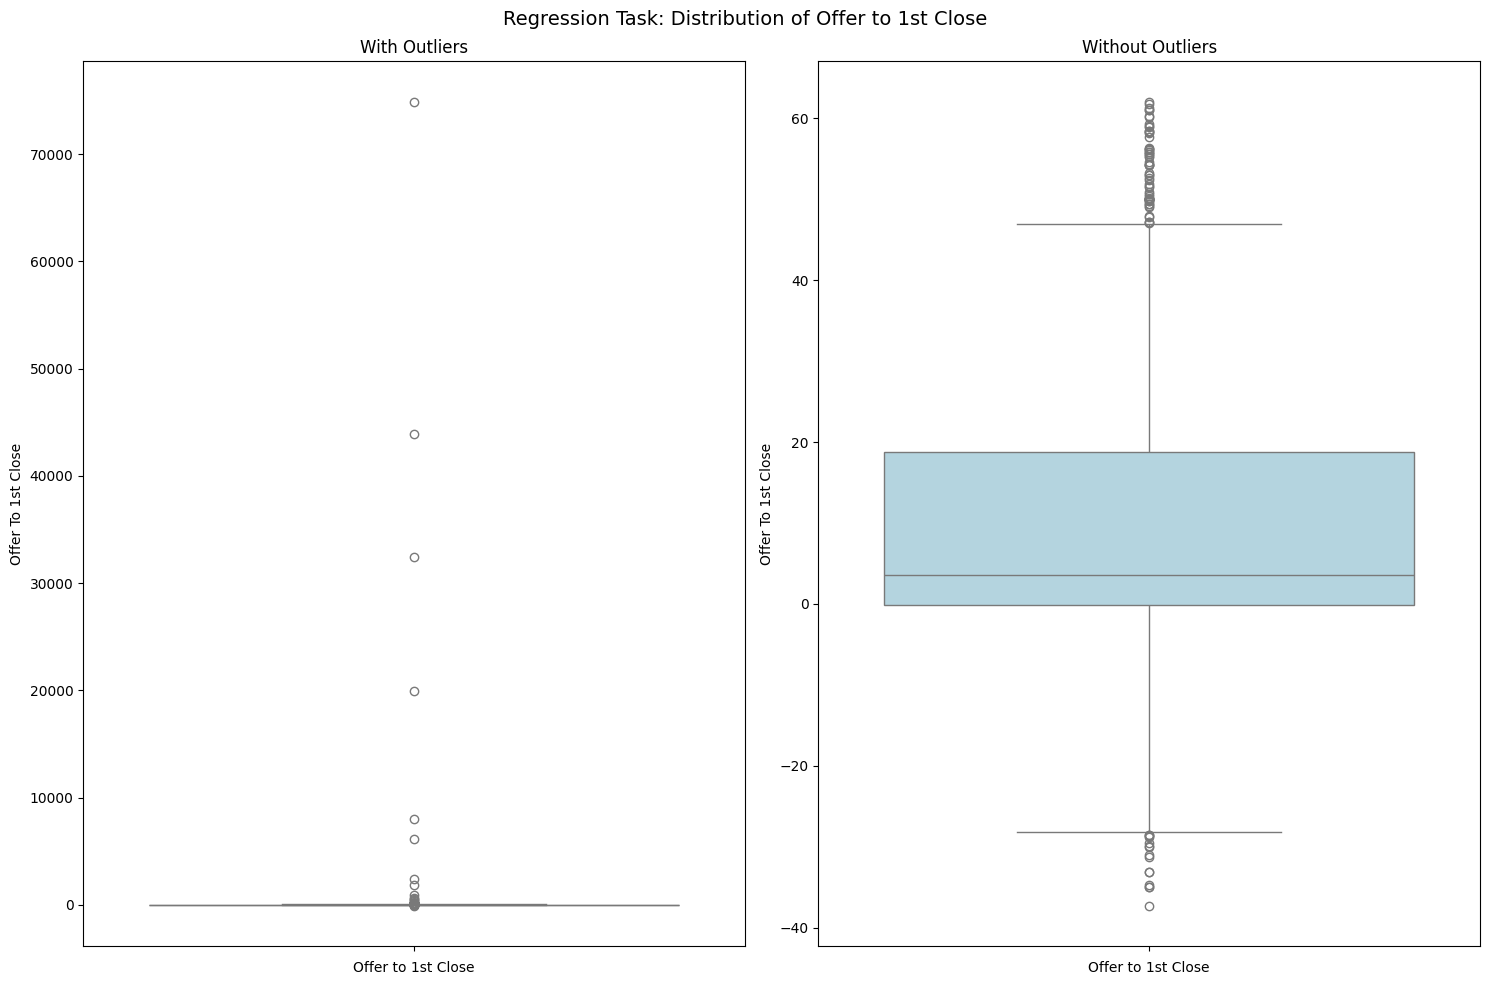

In [11]:
def display_distribution(df_dev_filtered, df_dev_correlation):
    """
    Display distribution of target variable before and after removing outliers.
    """
    df_no_outliers = df_dev_filtered.copy()
    df_with_outliers = df_dev_correlation.copy()

    fig, axs = plt.subplots(ncols=2, figsize=(15, 10))

    sns.boxplot(data=df_with_outliers, y='Offer To 1st Close', color='lightblue', ax=axs[0])
    axs[0].set_title('With Outliers')
    axs[0].set_xlabel('Offer to 1st Close')

    sns.boxplot(data=df_no_outliers, y='Offer To 1st Close', color='lightblue', ax=axs[1])
    axs[1].set_title('Without Outliers')
    axs[1].set_xlabel('Offer to 1st Close')

    fig.suptitle('Regression Task: Distribution of Offer to 1st Close', fontsize=14)
    plt.tight_layout()
    plt.show()

display_distribution(df_dev_filtered, df_dev_correlation)

### Dimensionality Reduction


Number of components after PCA: 9
Explained variance ratio: 0.96


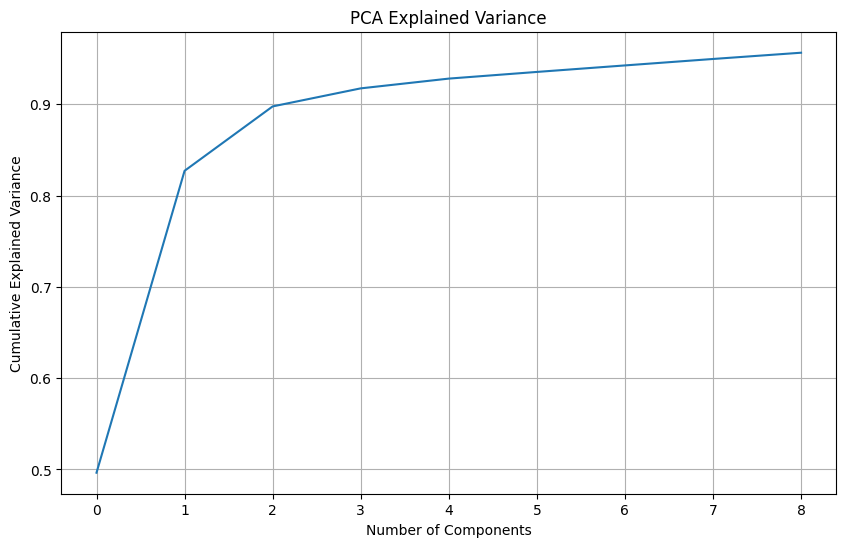

In [12]:
def apply_dimensionality_reduction(df_dev, df_test, n_components=0.95):
    """
    Apply dimensionality reduction techniques to the data.
    """
    X_dev = df_dev.drop(columns=['Offer To 1st Close'])
    y_dev = df_dev['Offer To 1st Close']
    
    X_test = df_test.drop(columns=['Offer To 1st Close'])
    y_test = df_test['Offer To 1st Close']
    
    pca = PCA(n_components=n_components, random_state=42)
    X_dev_pca = pca.fit_transform(X_dev)
    X_test_pca = pca.transform(X_test)

    print(f"\nNumber of components after PCA: {pca.n_components_}")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.2f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid(True)
    plt.show()
    
    df_dev_reduced = pd.DataFrame(X_dev_pca, columns=[f'PC{i+1}' for i in range(X_dev_pca.shape[1])])
    df_test_reduced = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])
    
    df_dev_reduced['Offer To 1st Close'] = y_dev.reset_index(drop=True)
    df_test_reduced['Offer To 1st Close'] = y_test.reset_index(drop=True)
    
    df_dev_reduced.to_csv('./output_csv/Final_Output_Reg_dev.csv', index=False)
    df_test_reduced.to_csv('./output_csv/Final_Output_Reg_test.csv', index=False)
    
    return df_dev_reduced, df_test_reduced

df_dev_reduced, df_test_reduced = apply_dimensionality_reduction(df_dev_filtered, df_test_correlation)

### Model Training

In [13]:
def split_data(df, target_col='Offer To 1st Close'):
    """
    Preprocess the data with feature engineering and scaling
    """
    X = df.drop(columns=target_col)
    y = df[target_col]
    return X, y

In [14]:
def get_enhanced_model_params():
    """Return enhanced model parameters with wider search space"""
    return {
        "Dummy Regressor": {
            "model": DummyRegressor(strategy='mean'),
            "params": {}
        },
        "Linear Regression": {
            "model": LinearRegression(n_jobs=-1),
            "params": {}
        },
        "Ridge Regression": {
            "model": Ridge(random_state=42, max_iter=10000),
            "params": {
                "alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            }
        },
        "Lasso Regression": {
            "model": Lasso(random_state=42, max_iter=10000),
            "params": {
                "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
            }
        },
        "ElasticNet Regression": {
            "model": ElasticNet(random_state=42, max_iter=10000),
            "params": {
                "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10],
                "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
            }
        },
        "Support Vector Regressor": {
            "model": SVR(),
            "params": {
                "kernel": ["rbf", "poly"],
                "C": [0.1, 1, 10],
                "gamma": ["scale", "auto"]
            }
        },
        "LightGBM": {
            "model": LGBMRegressor(
                random_state=42,
                force_col_wise=True,  
                min_data_in_leaf=10,  
                feature_fraction=0.8,  
                bagging_fraction=0.8, 
                bagging_freq=1,     
                verbose=-1         
            ),
            "params": {
                "n_estimators": [100, 200],
                "max_depth": [5, 7],
                "learning_rate": [0.01, 0.05],
                "num_leaves": [20, 31],
                "reg_alpha": [0.01, 0.1],     
                "reg_lambda": [0.01, 0.1]
            }
        },
        "Random Forest (Light)": {
            "model": RandomForestRegressor(random_state=42, n_jobs=-1),
            "params": {
                "n_estimators": [50, 100],
                "max_depth": [3, 5],
                "min_samples_split": [5, 10]
            }
        },
        "Gradient Boosting": {
            "model": GradientBoostingRegressor(random_state=42),
            "params": {
                "n_estimators": [50, 100],
                "max_depth": [3, 5],
                "learning_rate": [0.01, 0.05],
                "subsample": [0.8, 1.0],
                "min_samples_split": [5, 10]
            }
        },
        "Extra Trees": {
            "model": ExtraTreesRegressor(random_state=42, n_jobs=-1),
            "params": {
                "n_estimators": [50, 100],
                "max_depth": [3, 5],
                "min_samples_split": [5, 10]
            }
        },
        "Kernel Ridge": {
            "model": KernelRidge(kernel='rbf'),
            "params": {
                "alpha": [0.001, 0.01, 0.1, 1.0],
                "gamma": [0.001, 0.01, 0.1, 1.0]
            }
        },
        "Neural Network": {
            "model": MLPRegressor(
                random_state=42,
                max_iter=2000,          
                early_stopping=True,    
                validation_fraction=0.1, 
                n_iter_no_change=50,    
                batch_size='auto',      
                learning_rate='adaptive' 
            ),
            "params": {
                "hidden_layer_sizes": [(100,), (100, 50), (50, 25)],
                "learning_rate_init": [0.001, 0.005],
                "alpha": [0.0001, 0.001, 0.01],
                "activation": ['relu', 'tanh']
            }
        }
    }

In [15]:
def evaluate_models(model_params, X_train, y_train, X_val, y_val):
    """Evaluate models with RMSE as the primary metric"""
    results = []

    total_models = len(model_params)
    print(f"Evaluating {total_models} models...\n")

    for i, (name, mp) in enumerate(model_params.items(), 1):
        print(f"[{i}/{total_models}] Training and evaluating: {name}...", end=" ")

        try:
            if mp["params"]:
                grid = GridSearchCV(
                    mp["model"],
                    mp["params"],
                    cv=5,
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1,
                    verbose=0
                )
                grid.fit(X_train, y_train)
                best_model = grid.best_estimator_
                print("✓ (GridSearch complete)")
            else:
                best_model = mp["model"]
                best_model.fit(X_train, y_train)
                print("✓ (No tuning needed)")

            cv_scores = cross_val_score(best_model, X_train, y_train, cv=5,
                                      scoring='neg_root_mean_squared_error')
            cv_scores = -cv_scores

            y_pred = best_model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            mae = mean_absolute_error(y_val, y_pred)
            r2 = r2_score(y_val, y_pred)

            results.append({
                "Model": name,
                "RMSE": rmse,
                "MAE": mae,
                "R² Score": r2,
                "CV RMSE Mean": cv_scores.mean(),
                "CV RMSE Std": cv_scores.std()
            })

            train_sizes, train_scores, val_scores = learning_curve(
                best_model, X_train, y_train, cv=5,
                scoring='neg_root_mean_squared_error',
                train_sizes=np.linspace(0.1, 1.0, 10)
            )

            train_scores = -train_scores
            val_scores = -val_scores

            plt.figure(figsize=(10, 6))
            plt.plot(train_sizes, train_scores.mean(axis=1), label='Training RMSE')
            plt.plot(train_sizes, val_scores.mean(axis=1), label='Cross-validation RMSE')
            plt.fill_between(train_sizes,
                           train_scores.mean(axis=1) - train_scores.std(axis=1),
                           train_scores.mean(axis=1) + train_scores.std(axis=1),
                           alpha=0.1)
            plt.fill_between(train_sizes,
                           val_scores.mean(axis=1) - val_scores.std(axis=1),
                           val_scores.mean(axis=1) + val_scores.std(axis=1),
                           alpha=0.1)
            plt.title(f'Learning Curves - {name}')
            plt.xlabel('Training examples')
            plt.ylabel('Root Mean Squared Error')
            plt.legend()
            plt.grid(True)
            plt.show()

            # Plot residual plots
            residuals = y_val - y_pred
            plt.figure(figsize=(10, 6))
            plt.scatter(y_pred, residuals, alpha=0.5)
            plt.axhline(y=0, color='r', linestyle='--')
            plt.title(f'Residual Plot - {name}')
            plt.xlabel('Predicted Values')
            plt.ylabel('Residuals')
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"✗ Error with {name}: {str(e)}")
            continue

    results_df = pd.DataFrame(results)

    top5_models_df = results_df.sort_values(by="RMSE", ascending=True).head(5).reset_index(drop=True)

    return results_df, top5_models_df

In [16]:
def clean_column_names(df):
    df.columns = df.columns.str.replace(r"[^\w\d_]+", "_", regex=True)
    return df

In [17]:
def evaluate_best_model(model_params, X, y, top5_models_df):
    """
    Evaluate the best model on the test set
    """
    df_test = pd.read_csv('./output_csv/Final_Output_Reg_test.csv')
    X_test, y_test = split_data(df_test)
    X_test = clean_column_names(X_test)

    best_model_name = top5_models_df.iloc[0]['Model']
    best_model = model_params[best_model_name]['model']
    best_model.fit(X, y)

    dummy_model = model_params['Dummy Regressor']['model']
    dummy_model.fit(X, y)

    y_pred = best_model.predict(X_test)
    y_pred_dummy = dummy_model.predict(X_test)

    test_metrics = {
        "Model": best_model_name,
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R² Score": r2_score(y_test, y_pred),
        "Dummy RMSE": np.sqrt(mean_squared_error(y_test, y_pred_dummy)),
        "Dummy MAE": mean_absolute_error(y_test, y_pred_dummy),
        "Dummy R² Score": r2_score(y_test, y_pred_dummy)
    }

    metrics_df = pd.DataFrame([test_metrics])
    metrics_df.to_csv('./output_csv/best_model_Reg_test_results.csv', index=False)

    print("\nTest Set Performance:")
    display(metrics_df)

In [18]:
def main():
    try:
        df_dev = pd.read_csv('./output_csv/Final_Output_Reg_dev.csv')
        X, y = split_data(df_dev)
        X = clean_column_names(X)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        model_params = get_enhanced_model_params()
        results_df, top5_models_df = evaluate_models(model_params, X_train, y_train, X_val, y_val)

        print("\nTop 5 Models:")
        display(top5_models_df)

        results_df.to_csv('./output_csv/regression_results.csv', index=False)
        top5_models_df.to_csv('./output_csv/top5_regression_models.csv', index=False)

        evaluate_best_model(model_params, X, y, top5_models_df)
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        raise

Evaluating 12 models...

[1/12] Training and evaluating: Dummy Regressor... ✓ (No tuning needed)


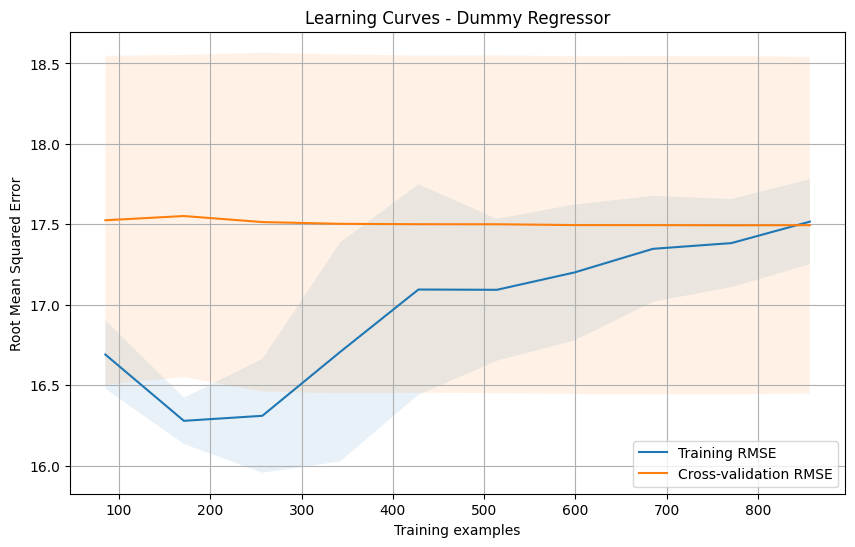

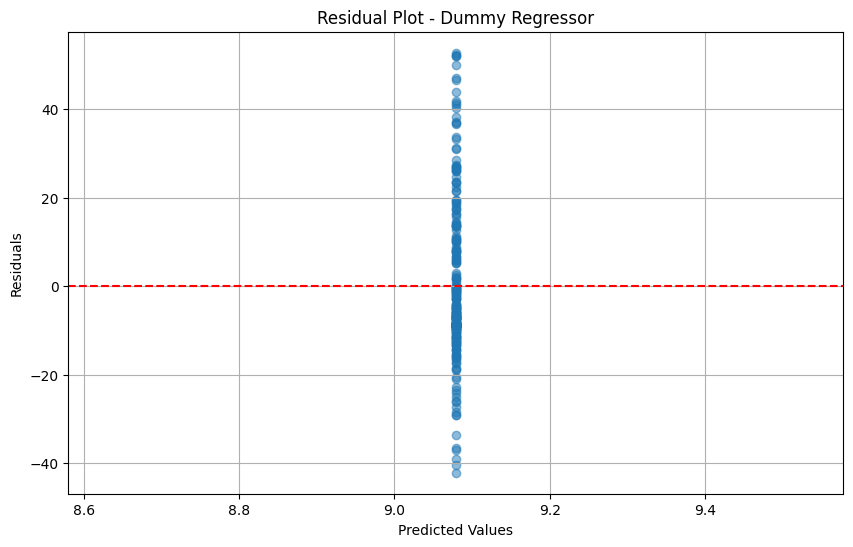

[2/12] Training and evaluating: Linear Regression... ✓ (No tuning needed)


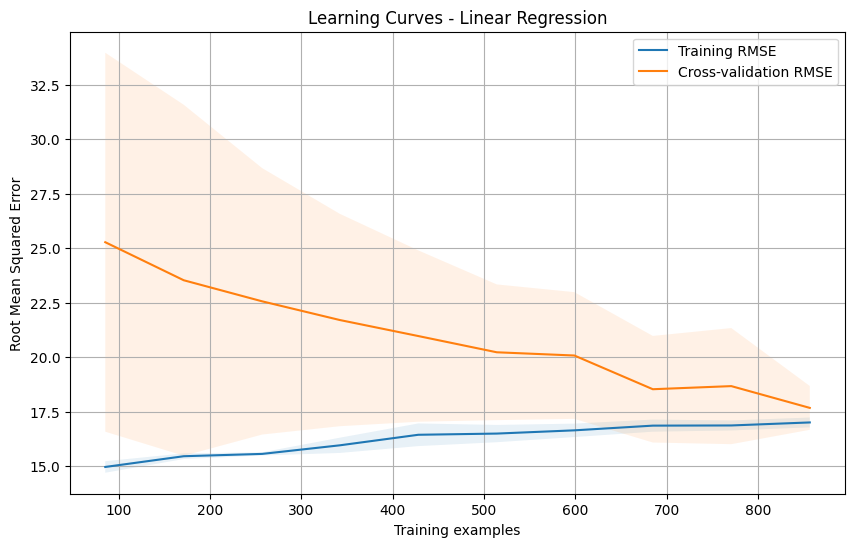

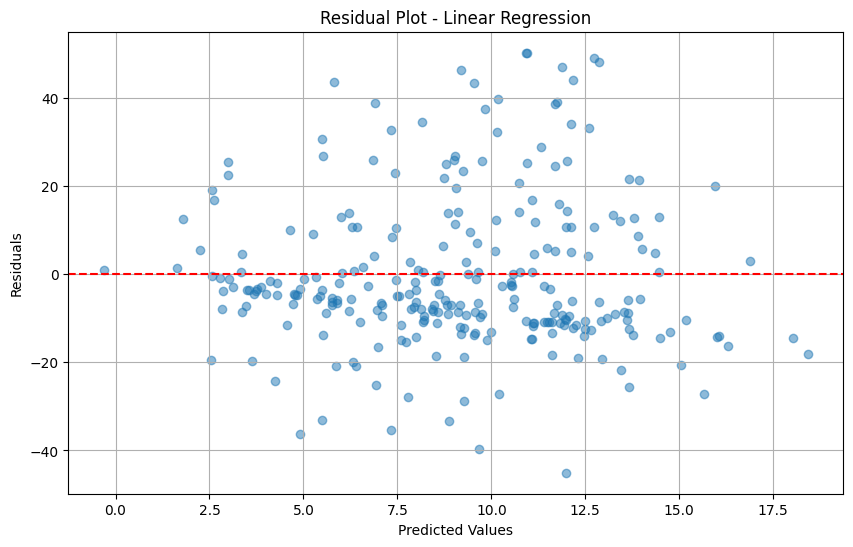

[3/12] Training and evaluating: Ridge Regression... ✓ (GridSearch complete)


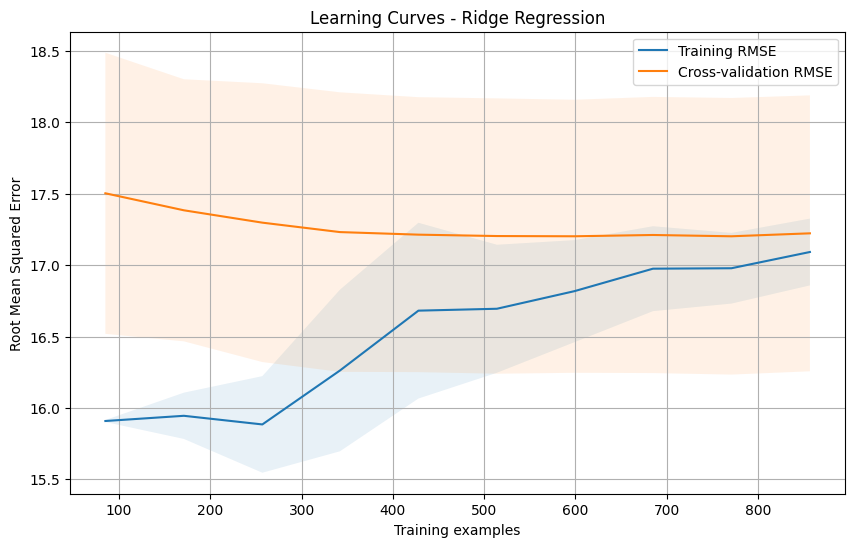

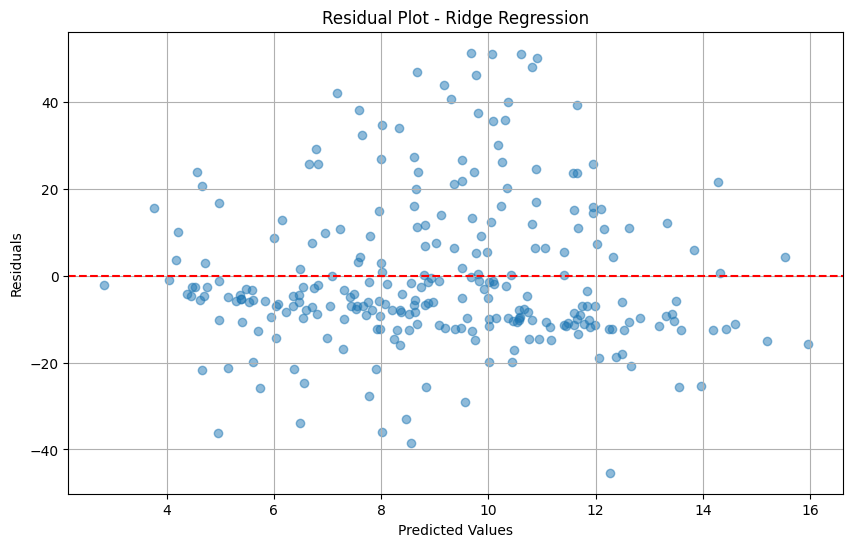

[4/12] Training and evaluating: Lasso Regression... ✓ (GridSearch complete)


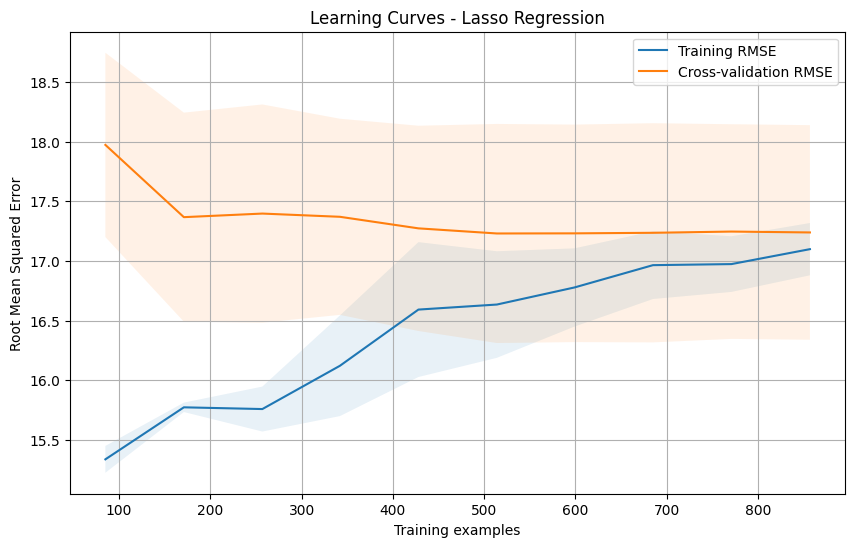

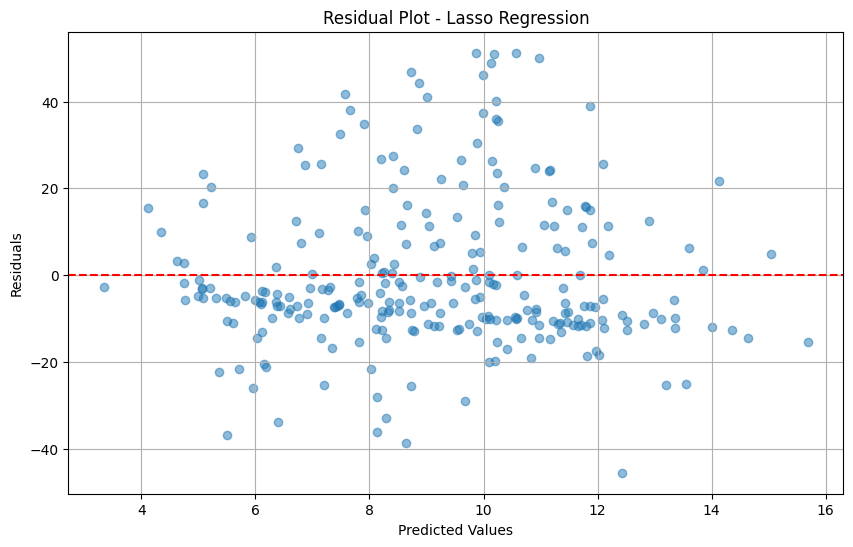

[5/12] Training and evaluating: ElasticNet Regression... ✓ (GridSearch complete)


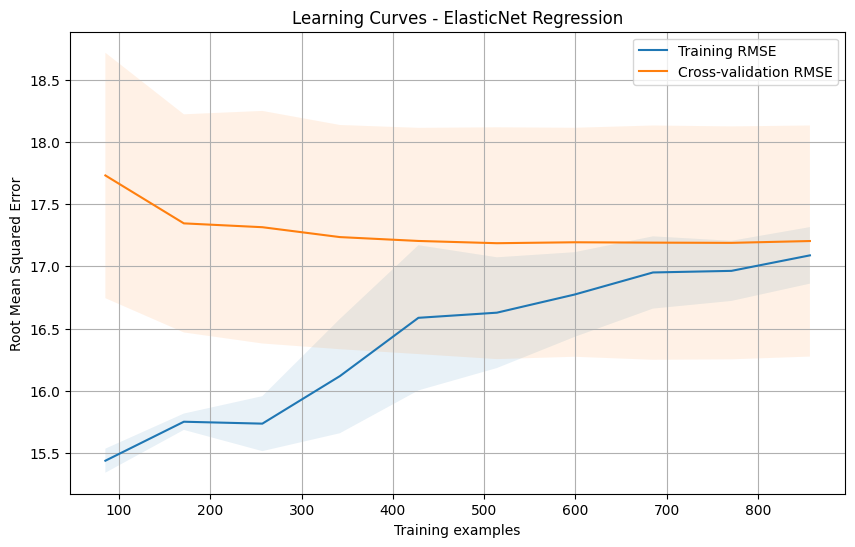

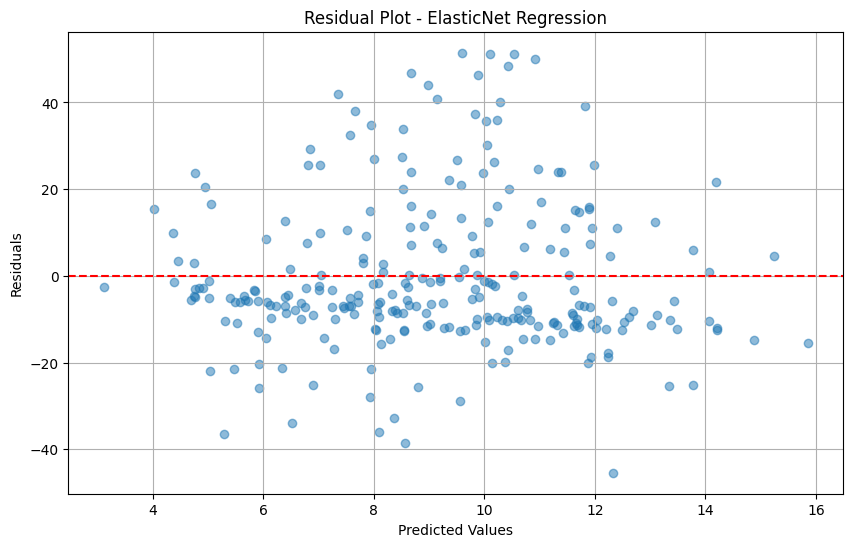

[6/12] Training and evaluating: Support Vector Regressor... ✓ (GridSearch complete)


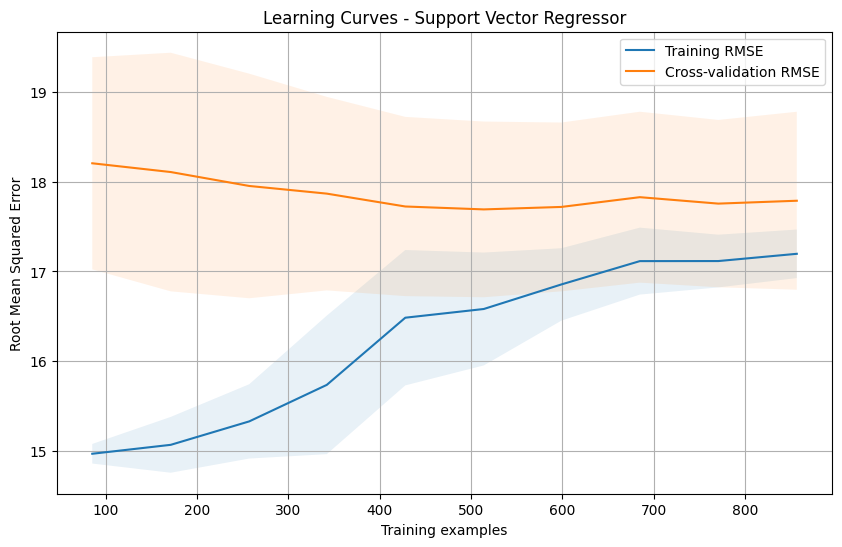

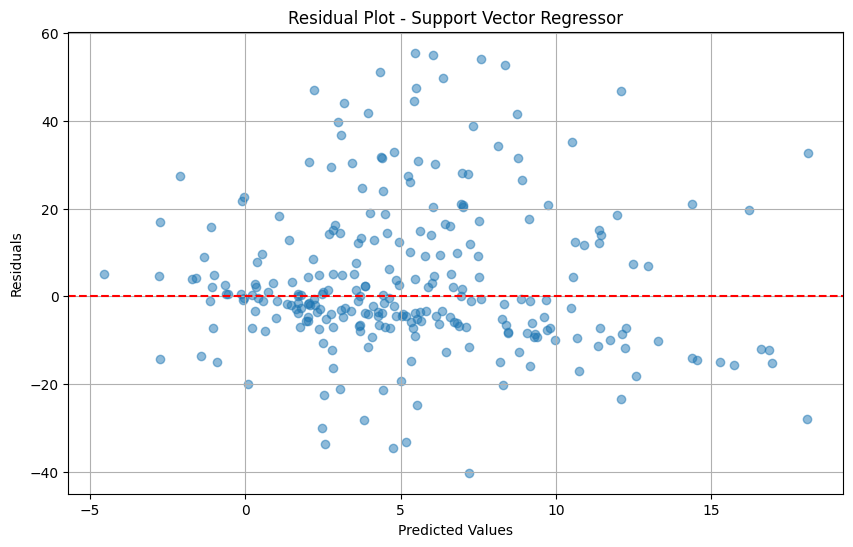

[7/12] Training and evaluating: LightGBM... ✓ (GridSearch complete)


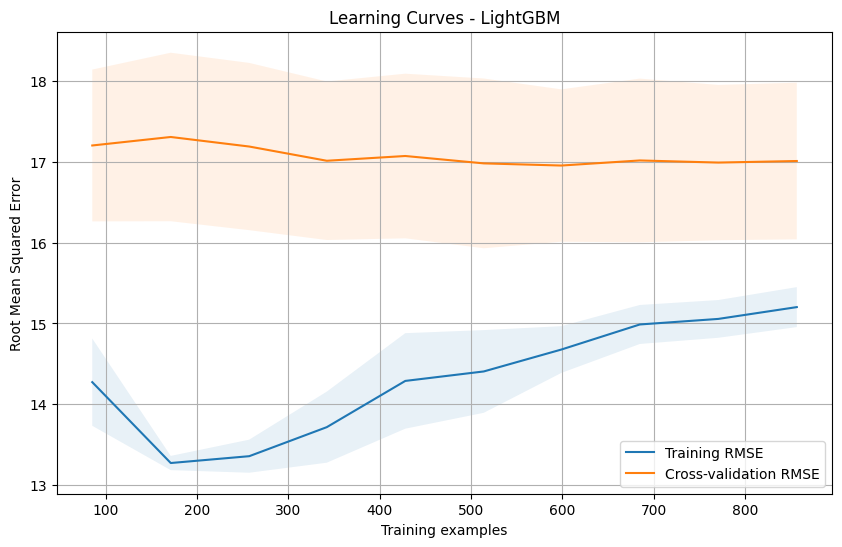

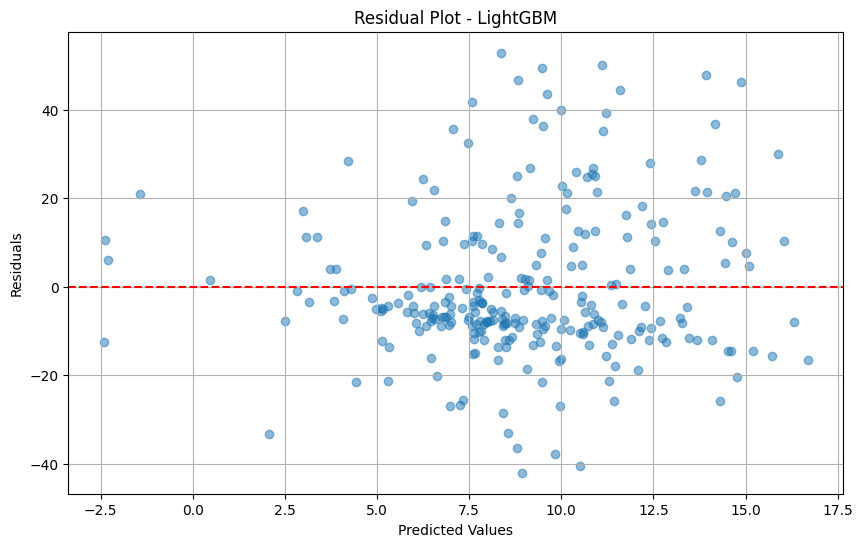

[8/12] Training and evaluating: Random Forest (Light)... ✓ (GridSearch complete)


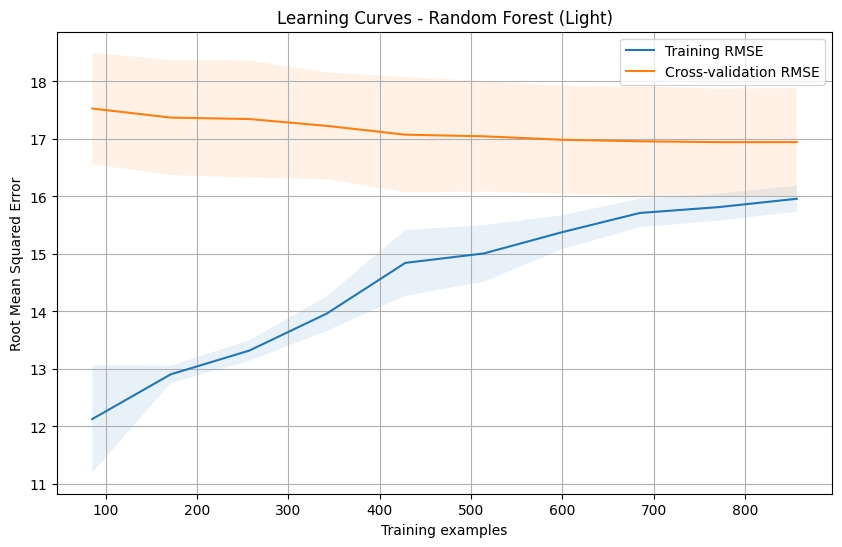

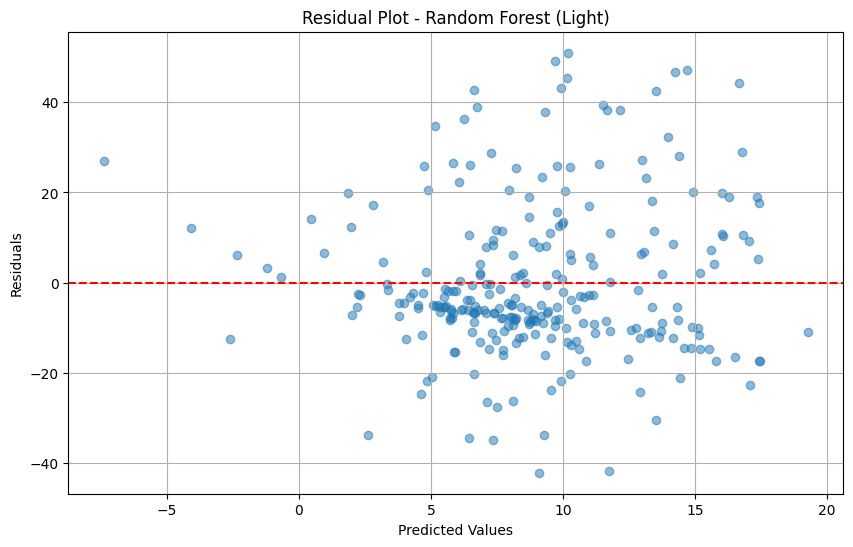

[9/12] Training and evaluating: Gradient Boosting... ✓ (GridSearch complete)


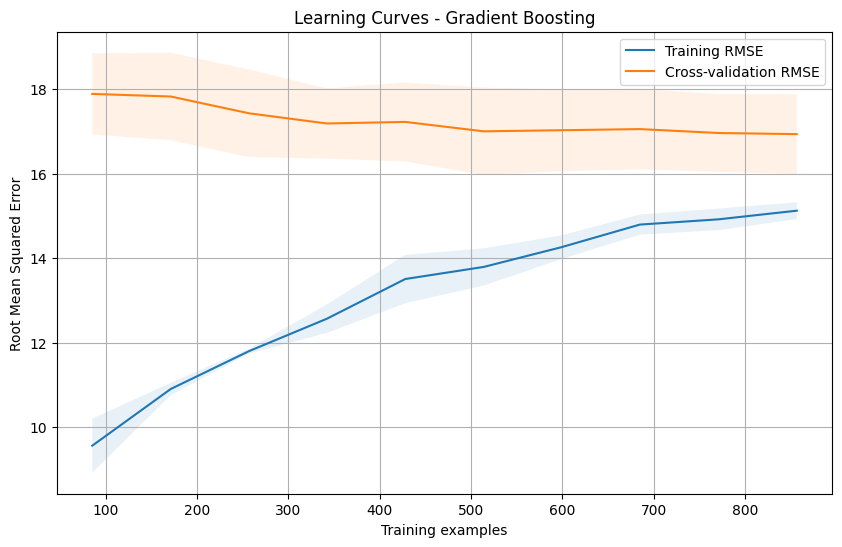

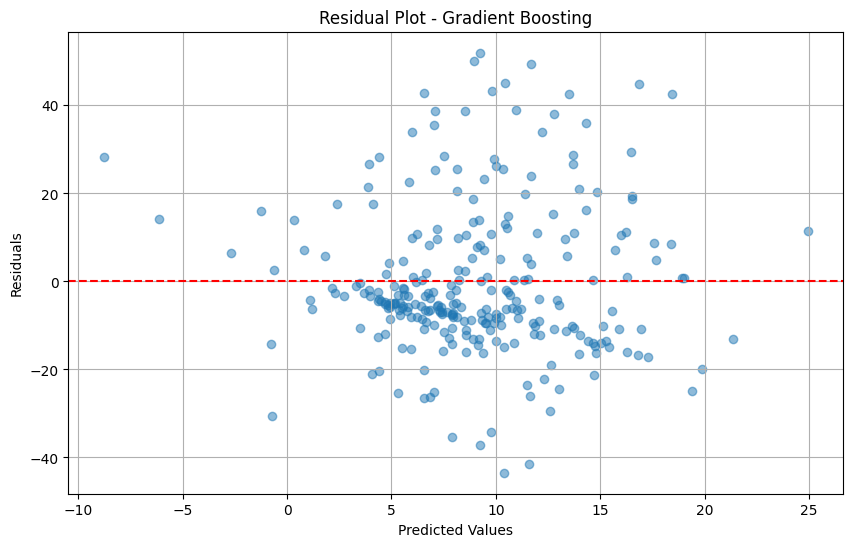

[10/12] Training and evaluating: Extra Trees... ✓ (GridSearch complete)


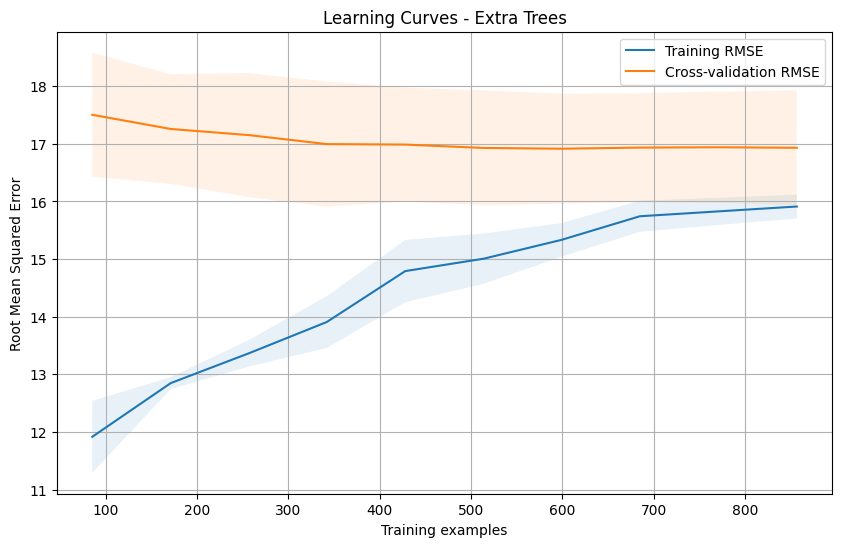

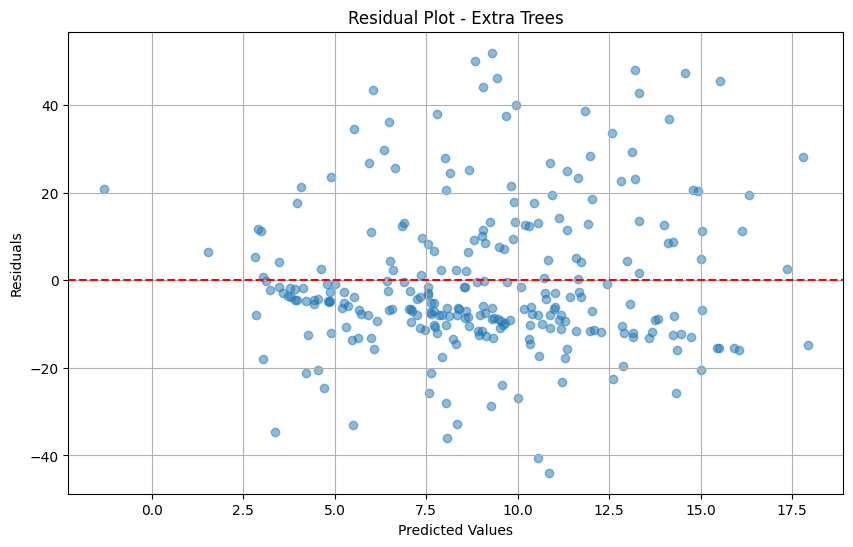

[11/12] Training and evaluating: Kernel Ridge... ✓ (GridSearch complete)


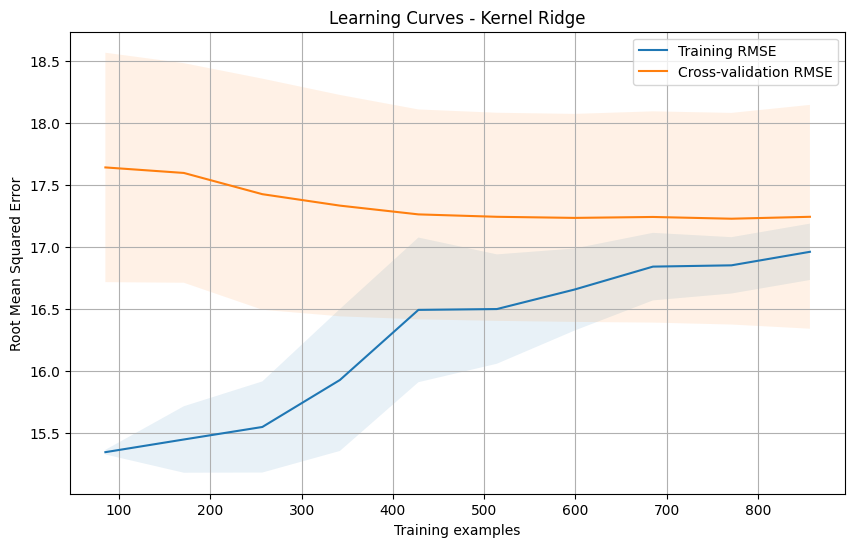

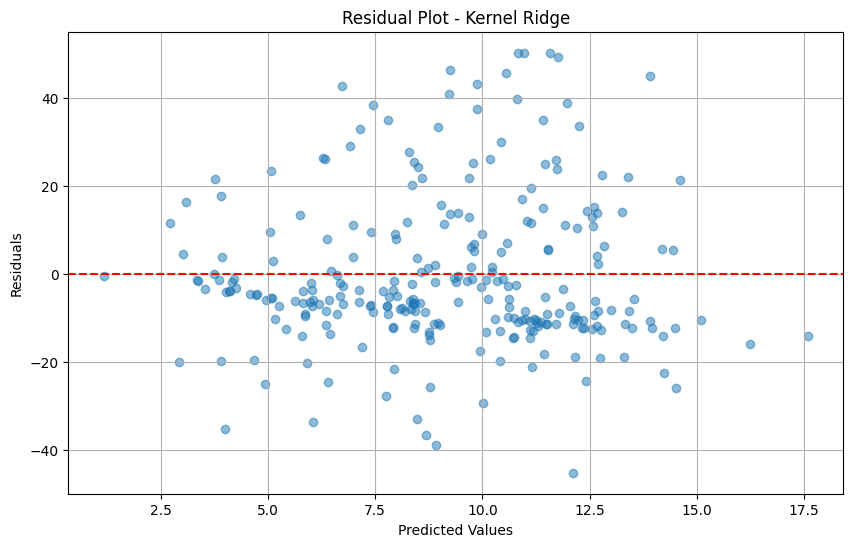

[12/12] Training and evaluating: Neural Network... ✓ (GridSearch complete)


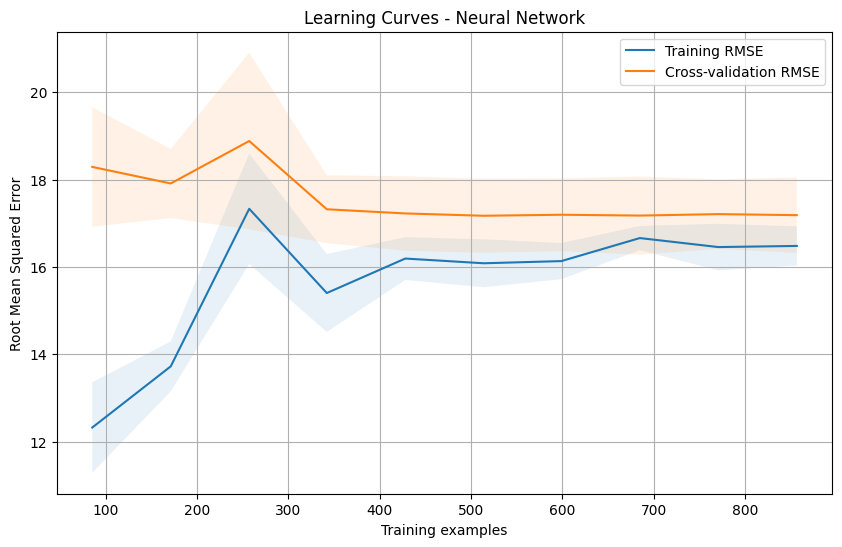

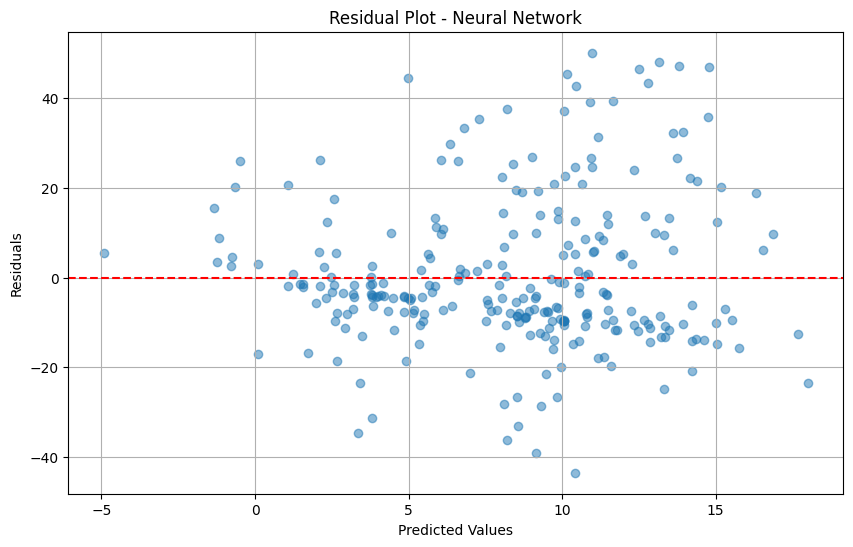


Top 5 Models:


,Model,RMSE,MAE,R² Score,CV RMSE Mean,CV RMSE Std
0,Neural Network,16.907733,12.801131,0.088601,17.106190,0.846319
1,Random Forest (Light),16.963234,12.943904,0.082608,16.945764,0.941667
2,Gradient Boosting,17.034087,12.941875,0.074928,16.958907,0.952624
3,Extra Trees,17.080162,13.063404,0.069917,16.930404,0.995921
4,LightGBM,17.088636,13.084238,0.068994,17.002019,0.963417



Test Set Performance:


,Model,RMSE,MAE,R² Score,Dummy RMSE,Dummy MAE,Dummy R² Score
0,Neural Network,6201.474177,558.784106,-0.007831,6201.435582,559.418876,-0.007818


In [19]:
main()